In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import diffxpy.api as de
import os

In [2]:
files = os.listdir("./H5ADfiles/")

In [3]:
Remove = []
TgoodID = []
for i in open("./OUTPUT/Testis_Tgood_ID.txt","r").readlines():
    TgoodID.append(i.strip())

TpoorID = []
for i in open("./OUTPUT/Testis_Tpoor_ID.txt","r").readlines():
    TpoorID.append(i.strip())

print("There are "+str(len(TgoodID))+" subjects in Group A.")
print("There are "+str(len(TpoorID))+" subjects in Group B.\n")

There are 146 subjects in Group A.
There are 183 subjects in Group B.



In [5]:
myTissues = ['AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad', #大脑-额叶皮层（BA9）
             'AnnData_GTEx_v10_Brain - Substantia nigra.h5ad', #脑-黑质
             'AnnData_GTEx_v10_Brain - Amygdala.h5ad', #大脑-杏仁核  #
             'AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad', #大脑-前扣带皮层（BA24）
             'AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad', #脑尾节（基底节）
             'AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad', #大脑-小脑半球
             'AnnData_GTEx_v10_Brain - Cerebellum.h5ad', #大脑-小脑
             'AnnData_GTEx_v10_Brain - Cortex.h5ad', #大脑皮层
             'AnnData_GTEx_v10_Brain - Hippocampus.h5ad', #大脑-海马
             'AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad', #脑-伏隔核（基底节）
             'AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad', #脑-Putamen（基底神经节）
             #'AnnData_GTEx_v10_Brain - Spinal cord (cervical c-1).h5ad' #脑-脊髓（颈c-1）
             ] + ['AnnData_GTEx_v10_Testis.h5ad']

In [6]:
GroupG_SubjIDs = set(TgoodID)
GroupP_SubjIDs = set(TpoorID)
UsedTis = []
NonUsedTis = []

for file in myTissues:
    if file.count("AnnData_GTEx_v10_") == 1 and file.count(".h5ad") == 1:
        if file not in Remove:
            print(file)
            myadata = 0
            myadata = sc.read("./H5ADfiles/"+file)
            AllID = myadata.obs.SUBJID.to_list()
            TmpA = GroupG_SubjIDs.intersection(set(AllID))
            TmpB = GroupP_SubjIDs.intersection(set(AllID))
            if min([len(TmpA),len(TmpB)]) < 5:
                print("$Group TestisGood subject numbers now is: "+str(len(list(TmpA)))+".")
                print("$Group TestisPoor subject numbers now is: "+str(len(list(TmpB)))+".")
                print("$ "+file+" is removed.\n")
                NonUsedTis.append(file)
            else:
                UsedTis.append(file)
                GroupG_SubjIDs = GroupG_SubjIDs.intersection(set(AllID))
                GroupP_SubjIDs = GroupP_SubjIDs.intersection(set(AllID))
                print("&&&&&&Group TestisGood subject numbers now is: "+str(len(list(GroupG_SubjIDs)))+".")
                print("&&&&&&Group TestisPoor subject numbers now is: "+str(len(list(GroupP_SubjIDs)))+".")
                print("&&&&&&&&&& "+file+" is used.\n")              
     
print("The tissues used here:")
print(UsedTis)
print("The tissues Non-used here:")
print(NonUsedTis)

AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad
&&&&&&Group TestisGood subject numbers now is: 56.
&&&&&&Group TestisPoor subject numbers now is: 41.
&&&&&&&&&& AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad is used.

AnnData_GTEx_v10_Brain - Substantia nigra.h5ad
&&&&&&Group TestisGood subject numbers now is: 27.
&&&&&&Group TestisPoor subject numbers now is: 24.
&&&&&&&&&& AnnData_GTEx_v10_Brain - Substantia nigra.h5ad is used.

AnnData_GTEx_v10_Brain - Amygdala.h5ad
&&&&&&Group TestisGood subject numbers now is: 14.
&&&&&&Group TestisPoor subject numbers now is: 19.
&&&&&&&&&& AnnData_GTEx_v10_Brain - Amygdala.h5ad is used.

AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad
&&&&&&Group TestisGood subject numbers now is: 11.
&&&&&&Group TestisPoor subject numbers now is: 14.
&&&&&&&&&& AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad is used.

AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad
&&&&&&Group TestisGood subject numbers now is: 10.
&&&

In [7]:
Tissues = []
Log2FC_less = []
Log2FC_larger = []
Total = []

myTisDiffResults = {}

for file in UsedTis:
    print("Analysing: $$$ "+file)
    myadata = sc.read("./H5ADfiles/"+file)
    myGenes = myadata.var["Symbol"].to_list()
    myadata.var_names = myGenes
    myadata.var_names_make_unique()
    
    AllID = myadata.obs.SUBJID.to_list()
    TGbool = [x in GroupG_SubjIDs for x in AllID]
    TPbool = [x in GroupP_SubjIDs for x in AllID]
    myadataTG = myadata[TGbool]
    myadataTP = myadata[TPbool]
    myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
    myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)
    myadataGP = ad.concat([myadataTG, myadataTP], axis=0)
    
    myadataGP.X = myadataGP.X.astype(np.float64)
    sc.pp.normalize_total(myadataGP, target_sum=1e4)
    sc.pp.log1p(myadataGP)
    
    test_results = de.test.two_sample(data=myadataGP, # AnnData 对象
                                      grouping=myadataGP.obs["Cluster"],  # 分组列（如细胞聚类结果）
                                      gene_names=myadataGP.var_names,
                                      test="rank")      # 基因名
    
    deg_table = test_results.summary()
    #significant_genes = deg_table[(deg_table["pval"] < 0.01) & (abs(deg_table["log2fc"]) > 0.5) & (deg_table["mean"]>0.01)]
    significant_genes = deg_table[(deg_table["pval"] < 0.01) & (deg_table["mean"]>0.01)] #注意假阳性
    significant_genes = deg_table[(deg_table["pval"] < 0.01) & (deg_table["mean"]>0.01)] #注意假阳性
    significant_genes2 = significant_genes.sort_values(by='log2fc')
    myT = file.split(".h")[0]
    significant_genes2.to_csv("./OUTPUT/Brain."+myT+".DE.csv")
    myTisDiffResults[file] = deg_table
    myT2 = myT.split("_v10_")[1]
    Tissues.append(myT2)
    Log2FC_less.append(significant_genes2[significant_genes2['log2fc'] < 0].shape[0])
    Log2FC_larger.append(significant_genes2[significant_genes2['log2fc'] > 0].shape[0])
    Total.append(significant_genes2.shape[0])


myD = {"Tissue":Tissues,"log2fc < 0":Log2FC_less,"log2fc > 0":Log2FC_larger,"Total.dif":Total}
mydf = pd.DataFrame(myD)
mydf = mydf.sort_values(by='Total.dif')
mydf

Analysing: $$$ AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Substantia nigra.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Amygdala.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Cerebellum.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Cortex.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Hippocampus.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Testis.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


,Tissue,log2fc < 0,log2fc > 0,Total.dif
8,Brain - Hippocampus,6,0,6
2,Brain - Amygdala,5,10,15
10,Brain - Putamen (basal ganglia),1,15,16
9,Brain - Nucleus accumbens (basal ganglia),2,21,23
6,Brain - Cerebellum,2,27,29
3,Brain - Anterior cingulate cortex (BA24),3,35,38
5,Brain - Cerebellar Hemisphere,8,33,41
1,Brain - Substantia nigra,127,0,127
7,Brain - Cortex,7,121,128
4,Brain - Caudate (basal ganglia),0,179,179


In [8]:
def transData(file,SubJG,SubJP):
    The_adata = sc.read("./H5ADfiles/"+file)
    myGenes = The_adata.var["Symbol"].to_list()
    The_adata.var_names = myGenes
    The_adata.var_names_make_unique()    
    AllID = The_adata.obs.SUBJID.to_list()
    TAbool = [x in SubJG for x in AllID]
    TBbool = [x in SubJP for x in AllID]
    The_adataTA = The_adata[TAbool]
    The_adataTB = The_adata[TBbool]
    The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
    The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)
    The_adataTATB = ad.concat([The_adataTA, The_adataTB], axis=0)
    
    The_adataTATB.X = The_adataTATB.X.astype(np.float64)
    sc.pp.normalize_total(The_adataTATB, target_sum=1e4)
    sc.pp.log1p(The_adataTATB)
    return The_adataTATB


def plotGene(The_adataTATB,TissueName,group,Gene,): 
    # 将数据转换为 DataFrame
    df = pd.DataFrame({
        'log(CPM + 1)': The_adataTATB[:,Gene].X.flatten(),  # 获取基因表达数据
        group: The_adataTATB.obs['Cluster']            # 分组信息
    })
    plt.close()
    plt.ioff()
    fig, ax = plt.subplots(figsize=(3, 4), constrained_layout=True)
    # 绘制箱线图
    sns.boxplot(
        data=df,
        x=group,
        y='log(CPM + 1)',
        width=0.5,
        #palette='Set2',       # 配色方案
        fill=False,
        showfliers=False,      # 是否显示离群点
        ax=ax
    )
    sns.swarmplot(
        data=df,
        x=group,
        y="log(CPM + 1)",
        hue="Cluster",          # 指定颜色分组列
        palette="Set2",
        size=5,
        alpha=0.7,
        ax=ax
    )

    ax.set_title(Gene, fontstyle="italic", color="black",fontsize=25)
    #plt.xticks(rotation=45)  # 旋转标签

    ax.set_ylabel('log(CPM + 1)',fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.set_xlabel(TissueName,fontsize=20)
    save_path = "/mnt/h/GTEx/my_plots/Testis_"+TissueName+"."+Gene+".pdf"
    fig.savefig(save_path, dpi=300,transparent=False)
    plt.show(fig)
    plt.close(fig)



In [9]:
mySub = transData('AnnData_GTEx_v10_Brain - Substantia nigra.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)

/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2193475084.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
/tmp/ipykernel_438/2193475084.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)


In [10]:
mySub.obs

,SMPTHNTS,SMTSD,SUBJID,SEX,AGE,DTHHRDY,Cluster
GTEX-14C5O-0011-R2a-SM-5ZZV2,NaN,Brain - Substantia nigra,GTEX-14C5O,1.0,60-69,4.0,T.good
GTEX-17EVP-0011-R2a-SM-7LG4W,NaN,Brain - Substantia nigra,GTEX-17EVP,1.0,40-49,2.0,T.good
GTEX-1A3MX-0011-R2b-SM-7EWFL,NaN,Brain - Substantia nigra,GTEX-1A3MX,1.0,60-69,4.0,T.good
GTEX-1B8L1-0011-R2a-SM-9OSVL,NaN,Brain - Substantia nigra,GTEX-1B8L1,1.0,60-69,2.0,T.good
GTEX-1E1VI-0011-R2a-SM-9QEGS,NaN,Brain - Substantia nigra,GTEX-1E1VI,1.0,50-59,2.0,T.good
GTEX-1KWVE-0011-R2a-SM-G8OLX,NaN,Brain - Substantia nigra,GTEX-1KWVE,1.0,30-39,1.0,T.good
GTEX-1MJK2-0011-R2b-SM-EXUS5,NaN,Brain - Substantia nigra,GTEX-1MJK2,1.0,50-59,2.0,T.good
GTEX-1PIIG-0011-R2b-SM-F648W,NaN,Brain - Substantia nigra,GTEX-1PIIG,1.0,30-39,0.0,T.good
GTEX-11GSO-0011-R2a-SM-57WDF,NaN,Brain - Substantia nigra,GTEX-11GSO,1.0,60-69,2.0,T.poor
GTEX-11PRG-0011-R2a-SM-69LQ5,NaN,Brain - Substantia nigra,GTEX-11PRG,1.0,50-59,2.0,T.poor


In [11]:
gene_name = "NNT"

# 创建一个包含细胞barcode和基因表达量的DataFrame
gene_df = pd.DataFrame({
    'cell_barcode': mySub.obs.SUBJID,
    gene_name: mySub.obs_vector(gene_name)
})
gene_df

,cell_barcode,NNT
GTEX-14C5O-0011-R2a-SM-5ZZV2,GTEX-14C5O,0.097121
GTEX-17EVP-0011-R2a-SM-7LG4W,GTEX-17EVP,0.086734
GTEX-1A3MX-0011-R2b-SM-7EWFL,GTEX-1A3MX,0.103607
GTEX-1B8L1-0011-R2a-SM-9OSVL,GTEX-1B8L1,0.109124
GTEX-1E1VI-0011-R2a-SM-9QEGS,GTEX-1E1VI,0.042666
GTEX-1KWVE-0011-R2a-SM-G8OLX,GTEX-1KWVE,0.105276
GTEX-1MJK2-0011-R2b-SM-EXUS5,GTEX-1MJK2,0.107436
GTEX-1PIIG-0011-R2b-SM-F648W,GTEX-1PIIG,0.100350
GTEX-11GSO-0011-R2a-SM-57WDF,GTEX-11GSO,0.054671
GTEX-11PRG-0011-R2a-SM-69LQ5,GTEX-11PRG,0.041601


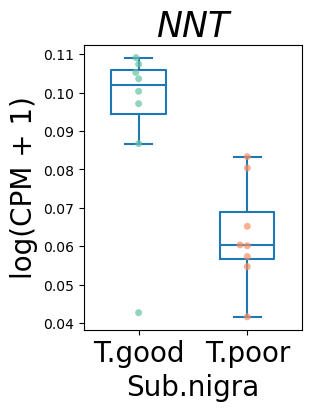

In [12]:
plotGene(mySub,"Sub.nigra","Cluster","NNT")

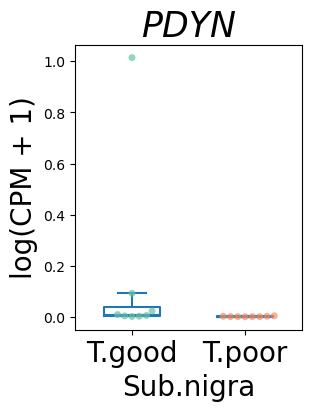

In [13]:
plotGene(mySub,"Sub.nigra","Cluster","PDYN")

In [14]:
gene_df = pd.DataFrame({
    'cell_barcode': mySub.obs.SUBJID,
    gene_name: mySub.obs_vector("HIPK4")
})
gene_df

,cell_barcode,NNT
GTEX-14C5O-0011-R2a-SM-5ZZV2,GTEX-14C5O,0.002917
GTEX-17EVP-0011-R2a-SM-7LG4W,GTEX-17EVP,0.003744
GTEX-1A3MX-0011-R2b-SM-7EWFL,GTEX-1A3MX,0.002689
GTEX-1B8L1-0011-R2a-SM-9OSVL,GTEX-1B8L1,0.002703
GTEX-1E1VI-0011-R2a-SM-9QEGS,GTEX-1E1VI,0.000635
GTEX-1KWVE-0011-R2a-SM-G8OLX,GTEX-1KWVE,0.001214
GTEX-1MJK2-0011-R2b-SM-EXUS5,GTEX-1MJK2,0.190986
GTEX-1PIIG-0011-R2b-SM-F648W,GTEX-1PIIG,0.009824
GTEX-11GSO-0011-R2a-SM-57WDF,GTEX-11GSO,0.001766
GTEX-11PRG-0011-R2a-SM-69LQ5,GTEX-11PRG,0.000262


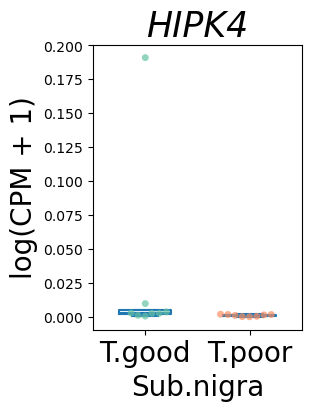

In [15]:
plotGene(mySub,"Sub.nigra","Cluster","HIPK4")

In [16]:
GroupG_SubjIDs.remove('GTEX-1MJK2')

In [17]:
GroupG_SubjIDs.remove('GTEX-1E1VI')

In [29]:
Tissues = []
Log2FC_less = []
Log2FC_larger = []
Total = []

myTisDiffResults = {}

for file in UsedTis:
    print("Analysing: $$$ "+file)
    myadata = sc.read("./H5ADfiles/"+file)
    myGenes = myadata.var["Symbol"].to_list()
    myadata.var_names = myGenes
    myadata.var_names_make_unique()
    
    AllID = myadata.obs.SUBJID.to_list()
    TGbool = [x in GroupG_SubjIDs for x in AllID]
    TPbool = [x in GroupP_SubjIDs for x in AllID]
    myadataTG = myadata[TGbool]
    myadataTP = myadata[TPbool]
    myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
    myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)
    myadataGP = ad.concat([myadataTG, myadataTP], axis=0)
    
    myadataGP.X = myadataGP.X.astype(np.float64)
    sc.pp.normalize_total(myadataGP, target_sum=1e4)
    sc.pp.log1p(myadataGP)
    
    test_results = de.test.two_sample(data=myadataGP, # AnnData 对象
                                      grouping=myadataGP.obs["Cluster"],  # 分组列（如细胞聚类结果）
                                      gene_names=myadataGP.var_names,
                                      test="rank")      # 基因名
    
    deg_table = test_results.summary()
    #significant_genes = deg_table[(deg_table["pval"] < 0.01) & (abs(deg_table["log2fc"]) > 0.5) & (deg_table["mean"]>0.01)]
    significant_genes = deg_table[(deg_table["pval"] < 0.01) & (deg_table["mean"]>0.01)] #注意假阳性
    significant_genes = deg_table[(deg_table["pval"] < 0.01) & (deg_table["mean"]>0.01)] #注意假阳性
    significant_genes2 = significant_genes.sort_values(by='log2fc')
    myT = file.split(".h")[0]
    significant_genes2.to_csv("./OUTPUT/Brain."+myT+".DE.csv")
    myTisDiffResults[file] = deg_table
    myT2 = myT.split("_v10_")[1]
    Tissues.append(myT2)
    Log2FC_less.append(significant_genes2[significant_genes2['log2fc'] < 0].shape[0])
    Log2FC_larger.append(significant_genes2[significant_genes2['log2fc'] > 0].shape[0])
    Total.append(significant_genes2.shape[0])


myD = {"Tissue":Tissues,"log2fc < 0":Log2FC_less,"log2fc > 0":Log2FC_larger,"Total.dif":Total}
mydf = pd.DataFrame(myD)
mydf = mydf.sort_values(by='Total.dif')
mydf

Analysing: $$$ AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Substantia nigra.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Amygdala.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Cerebellum.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Cortex.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Hippocampus.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Testis.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2806940464.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_438/2806940464.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


,Tissue,log2fc < 0,log2fc > 0,Total.dif
10,Brain - Putamen (basal ganglia),3,5,8
8,Brain - Hippocampus,13,1,14
9,Brain - Nucleus accumbens (basal ganglia),16,5,21
5,Brain - Cerebellar Hemisphere,19,14,33
6,Brain - Cerebellum,29,17,46
7,Brain - Cortex,17,78,95
4,Brain - Caudate (basal ganglia),1,95,96
0,Brain - Frontal Cortex (BA9),1,123,124
3,Brain - Anterior cingulate cortex (BA24),117,16,133
1,Brain - Substantia nigra,139,0,139


In [19]:
myTissues = ['AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad', #大脑-额叶皮层（BA9）
             'AnnData_GTEx_v10_Brain - Substantia nigra.h5ad', #脑-黑质
             'AnnData_GTEx_v10_Brain - Amygdala.h5ad', #大脑-杏仁核  #
             'AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad', #大脑-前扣带皮层（BA24）
             'AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad', #脑尾节（基底节）
             'AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad', #大脑-小脑半球
             'AnnData_GTEx_v10_Brain - Cerebellum.h5ad', #大脑-小脑
             'AnnData_GTEx_v10_Brain - Cortex.h5ad', #大脑皮层
             'AnnData_GTEx_v10_Brain - Hippocampus.h5ad', #大脑-海马
             'AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad', #脑-伏隔核（基底节）
             'AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad', #脑-Putamen（基底神经节）
             'AnnData_GTEx_v10_Testis.h5ad']

In [20]:
mySub = transData('AnnData_GTEx_v10_Brain - Substantia nigra.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myAmygdala = transData('AnnData_GTEx_v10_Brain - Amygdala.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myAnt = transData('AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myFro = transData('AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myCau = transData('AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myCortex = transData('AnnData_GTEx_v10_Brain - Cortex.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myCerebellum = transData('AnnData_GTEx_v10_Brain - Cerebellum.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myCere = transData('AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myNuc = transData('AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myHip = transData('AnnData_GTEx_v10_Brain - Hippocampus.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myPut = transData('AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad',GroupG_SubjIDs, GroupP_SubjIDs)
myTestis = transData('AnnData_GTEx_v10_Testis.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)

/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_438/2193475084.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
/tmp/ipykernel_438/2193475084.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)
/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values 

In [31]:
def plotTheGene(gene):
    plotGene(mySub,"Sub.nigra","Cluster",gene)
    plotGene(myAmygdala,"Amygdala","Cluster",gene)
    plotGene(myAnt,"Ant.cingulate","Cluster",gene)
    plotGene(myFro,"Front.Cortex","Cluster",gene)
    plotGene(myCau,"Caudate.b.g.","Cluster",gene)
    plotGene(myCortex,"Cortex","Cluster",gene)
    plotGene(myCerebellum,"Cerebellum","Cluster",gene)
    plotGene(myCere,"C.Hemisphere","Cluster",gene)
    plotGene(myNuc,"N.accumbens.b.g.","Cluster",gene)
    plotGene(myHip,"Hippocampus","Cluster",gene)
    plotGene(myPut,"Putamen.b.g.","Cluster",gene)
    plotGene(myTestis,"Testis","Cluster",gene)

In [30]:
#plotTheGene("GRM1")

In [31]:
#plotTheGene("PTPRT")

In [23]:
#plotTheGene("ALDH1A1")

In [24]:
#plotTheGene("DLEC1")

In [25]:
#plotTheGene("LYPD8")

In [26]:
#plotTheGene("ACOX2")

In [27]:
#plotTheGene("PSD4")

In [28]:
#plotTheGene("GABRG1")

In [34]:
mydf

,Tissue,log2fc < 0,log2fc > 0,Total.dif
10,Brain - Putamen (basal ganglia),3,5,8
8,Brain - Hippocampus,13,1,14
9,Brain - Nucleus accumbens (basal ganglia),16,5,21
5,Brain - Cerebellar Hemisphere,19,14,33
6,Brain - Cerebellum,29,17,46
7,Brain - Cortex,17,78,95
4,Brain - Caudate (basal ganglia),1,95,96
0,Brain - Frontal Cortex (BA9),1,123,124
3,Brain - Anterior cingulate cortex (BA24),117,16,133
1,Brain - Substantia nigra,139,0,139


In [32]:
myTis = ["Testis", "Amygdala","Sub.nigra","Ant.cingulate","Front.Cortex", "Caudate.b.g.",
         "Cortex", "Cerebellum","C.Hemisphere","N.accumbens.b.g.",
        "Hippocampus","Putamen.b.g."]

In [33]:
myTisAdata = {"Testis":myTestis,
             "Amygdala":myAmygdala,
             "Sub.nigra":mySub,
             "Ant.cingulate":myAnt,
             "Front.Cortex":myFro,
             "Caudate.b.g.":myCau,
             "Cortex":myCortex,
             "Cerebellum":myCerebellum,
             "C.Hemisphere":myCere,
             "N.accumbens.b.g.":myNuc,
             "Hippocampus":myHip,
             "Putamen.b.g.":myPut}


In [34]:
myFiles={"Testis":'AnnData_GTEx_v10_Testis.h5ad',
             "Amygdala":'AnnData_GTEx_v10_Brain - Amygdala.h5ad',
             "Sub.nigra":'AnnData_GTEx_v10_Brain - Substantia nigra.h5ad',
             "Ant.cingulate":'AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad',
             "Front.Cortex":'AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad',
             "Caudate.b.g.":'AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad',
             "Cortex":'AnnData_GTEx_v10_Brain - Cortex.h5ad',
             "Cerebellum":'AnnData_GTEx_v10_Brain - Cerebellum.h5ad',
             "C.Hemisphere":'AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad',
             "N.accumbens.b.g.":'AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad',
             "Hippocampus":'AnnData_GTEx_v10_Brain - Hippocampus.h5ad',
             "Putamen.b.g.":'AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad'}
myTissues = ['AnnData_GTEx_v10_Brain - Frontal Cortex (BA9).h5ad', #大脑-额叶皮层（BA9）
             'AnnData_GTEx_v10_Brain - Substantia nigra.h5ad', #脑-黑质
             'AnnData_GTEx_v10_Brain - Amygdala.h5ad', #大脑-杏仁核  #
             'AnnData_GTEx_v10_Brain - Anterior cingulate cortex (BA24).h5ad', #大脑-前扣带皮层（BA24）
             'AnnData_GTEx_v10_Brain - Caudate (basal ganglia).h5ad', #脑尾节（基底节）
             'AnnData_GTEx_v10_Brain - Cerebellar Hemisphere.h5ad', #大脑-小脑半球
             'AnnData_GTEx_v10_Brain - Cerebellum.h5ad', #大脑-小脑
             'AnnData_GTEx_v10_Brain - Cortex.h5ad', #大脑皮层
             'AnnData_GTEx_v10_Brain - Hippocampus.h5ad', #大脑-海马
             'AnnData_GTEx_v10_Brain - Nucleus accumbens (basal ganglia).h5ad', #脑-伏隔核（基底节）
             'AnnData_GTEx_v10_Brain - Putamen (basal ganglia).h5ad', #脑-壳核（基底神经节）
             'AnnData_GTEx_v10_Testis.h5ad']

In [35]:
def searchGenePvalues(Gene):
    myPs = {}
    for t in myFiles.keys():
        f = myFiles[t]
        diff = myTisDiffResults[f]
        p = diff[diff.gene == Gene].pval
        myPs[t] = float(p)

    return myPs

In [49]:
def PlotOneGene(Gene,bbox_to_anchor=(0.01, 1)):
    myTisDf = pd.DataFrame(columns=['log(CPM + 1)', 'Group', 'Tissue'])
    for k in myTisAdata.keys():
        The_adataTATB = myTisAdata[k]
        df = pd.DataFrame({
            'log(CPM + 1)': The_adataTATB[:,Gene].X.flatten(),  # 获取基因表达数据
            'Group': The_adataTATB.obs['Cluster'],            # 分组信息
            'Tissue':k
        })
        myTisDf = pd.concat([myTisDf, df], ignore_index=True)

    fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)

    myorder = myTis
    # 绘制箱线图（显示中位数、四分位数等）
    sns.boxplot(
        data=myTisDf,
        x='Tissue', y='log(CPM + 1)', hue='Group',
        order=myorder,
        palette="Set1",
        #width=0.5,
        dodge = 2,
        gap=0.05,
        showfliers=False,
        legend=False,fill=False
    )

    # 绘制点图（显示数据分布）
    sns.stripplot(
        x='Tissue', y='log(CPM + 1)', hue='Group',
        order=myorder,
        palette="Set1",
        data=myTisDf,
        dodge =0.05,
        jitter=0.2, alpha=0.5, size=6
    )
    
    current_ylim = ax.get_ylim()
    extension_factor = 1.6  
    # 设置新的y轴范围
    ax.set_ylim(current_ylim[0], current_ylim[1]*extension_factor)
    
    #加p值
    TheY = current_ylim[1]
    myPvalues = searchGenePvalues(Gene)
    for k in myorder:
        p_value = myPvalues[k]
        # 添加p值文本
        x_position = list(myorder).index(k)
        myd = myTisDf[myTisDf["Tissue"]==k]
        ymax = myd['log(CPM + 1)'].max()
        mf = 1.35
        if 2*ymax > TheY and 1.3*ymax <= TheY:
            mf = 1.5
            #print("$")
        if 5*ymax > TheY and 2*ymax <= TheY:
            mf = 2.2
            #print("A")
        if 10*ymax > TheY and 5*ymax <= TheY:
            mf = 4
        if 20*ymax > TheY and 10*ymax <= TheY:
            mf = 6
            #print("B")
        if 50*ymax > TheY and 20*ymax <= TheY:
            mf = 12
        if 100*ymax > TheY and 50*ymax <= TheY:
            mf = 24
        if 100*ymax <= TheY:
            mf = 100
        
        if p_value < 0.001:
            ax.text(x_position, ymax*mf, 
               f"p={p_value:.2e}", 
               ha='center',
               rotation=70,          # 旋转角度
               va='center',          # 垂直居中
               size=13)
        else:
            ax.text(x_position, ymax*mf, 
               f"p={p_value:.4f}", 
               ha='center',
               rotation=70,          # 旋转角度
               va='center',          # 垂直居中
               size=13)

    # 添加图例和标题
    plt.title(Gene,size=25)
    plt.xlabel('')
    plt.ylabel('log(CPM + 1)',size=20)
    plt.legend(bbox_to_anchor=bbox_to_anchor,
               loc='upper left',
               fontsize='x-large',
               title =None,
               edgecolor="black")
    plt.xticks(rotation=45,ha='right',rotation_mode='anchor',size=15)
    plt.tight_layout()
    save_path = "/mnt/h/GTEx/my_plots/Box_Strip_"+Gene+".pdf"
    fig.savefig(save_path, dpi=300,transparent=False)
    plt.show(fig)
    plt.close(fig)

    return myTisDf

In [63]:
def PlotOneGene2(Gene,bbox_to_anchor=(0.01, 1)):
    myTisDf = pd.DataFrame(columns=['log(CPM + 1)', 'Group', 'Tissue'])
    for k in myTisAdata.keys():
        The_adataTATB = myTisAdata[k]
        df = pd.DataFrame({
            'log(CPM + 1)': The_adataTATB[:,Gene].X.flatten(),  # 获取基因表达数据
            'Group': The_adataTATB.obs['Cluster'],            # 分组信息
            'Tissue':k
        })
        myTisDf = pd.concat([myTisDf, df], ignore_index=True)

    fig, ax = plt.subplots(figsize=(9, 3.5), constrained_layout=True)

    myorder = myTis
    # 绘制箱线图（显示中位数、四分位数等）
    sns.boxplot(
        data=myTisDf,
        x='Tissue', y='log(CPM + 1)', hue='Group',
        order=myorder,
        palette="Set1",
        #width=0.5,
        dodge = 2,
        gap=0.05,
        showfliers=False,
        legend=False,fill=False
    )

    # 绘制点图（显示数据分布）
    sns.stripplot(
        x='Tissue', y='log(CPM + 1)', hue='Group',
        order=myorder,
        palette="Set1",
        data=myTisDf,
        dodge =0.05,
        jitter=0.2, alpha=0.5, size=6
    )
    
    current_ylim = ax.get_ylim()
    extension_factor = 1.6  
    # 设置新的y轴范围
    ax.set_ylim(current_ylim[0], current_ylim[1]*extension_factor)
    
    #加p值
    TheY = current_ylim[1]
    myPvalues = searchGenePvalues(Gene)
    for k in myorder:
        p_value = myPvalues[k]
        # 添加p值文本
        x_position = list(myorder).index(k)
        myd = myTisDf[myTisDf["Tissue"]==k]
        ymax = myd['log(CPM + 1)'].max()
        mf = 1.35
        if 2*ymax > TheY and 1.3*ymax <= TheY:
            mf = 1.5
            #print("$")
        if 5*ymax > TheY and 2*ymax <= TheY:
            mf = 2.2
            #print("A")
        if 10*ymax > TheY and 5*ymax <= TheY:
            mf = 4
        if 20*ymax > TheY and 10*ymax <= TheY:
            mf = 6
            #print("B")
        if 50*ymax > TheY and 20*ymax <= TheY:
            mf = 12
        if 100*ymax > TheY and 50*ymax <= TheY:
            mf = 24
        if 100*ymax <= TheY:
            mf = 100
        
        if p_value < 0.001:
            ax.text(x_position, ymax*mf, 
               f"p={p_value:.2e}", 
               ha='center',
               rotation=70,          # 旋转角度
               va='center',          # 垂直居中
               size=13)
        else:
            ax.text(x_position, ymax*mf, 
               f"p={p_value:.4f}", 
               ha='center',
               rotation=70,          # 旋转角度
               va='center',          # 垂直居中
               size=13)

    # 添加图例和标题
    plt.title(Gene,size=25)
    plt.xlabel('')
    plt.ylabel('log(CPM + 1)',size=20)
    plt.legend(bbox_to_anchor=bbox_to_anchor,
               loc='upper left',
               fontsize='x-large',
               title =None,
               edgecolor="black")
    #plt.xticks(rotation=45,ha='right',rotation_mode='anchor',size=15)
    ax.set_xticklabels([])
    plt.tight_layout()
    save_path = "/mnt/h/GTEx/my_plots/Box_Strip_"+Gene+".pdf"
    fig.savefig(save_path, dpi=300,transparent=False)
    plt.show(fig)
    plt.close(fig)

    return myTisDf

/tmp/ipykernel_438/2203974469.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_438/3338318438.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_438/2203974469.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


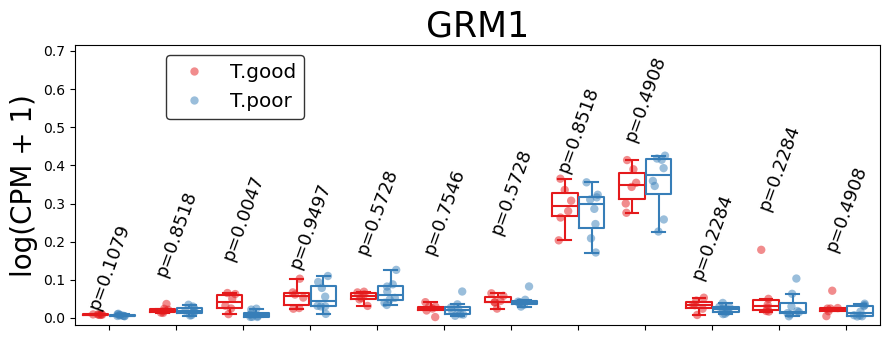

In [64]:
tmp = PlotOneGene2("GRM1",bbox_to_anchor=(0.1, 1))

/tmp/ipykernel_438/3300590048.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_438/3338318438.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_438/3300590048.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


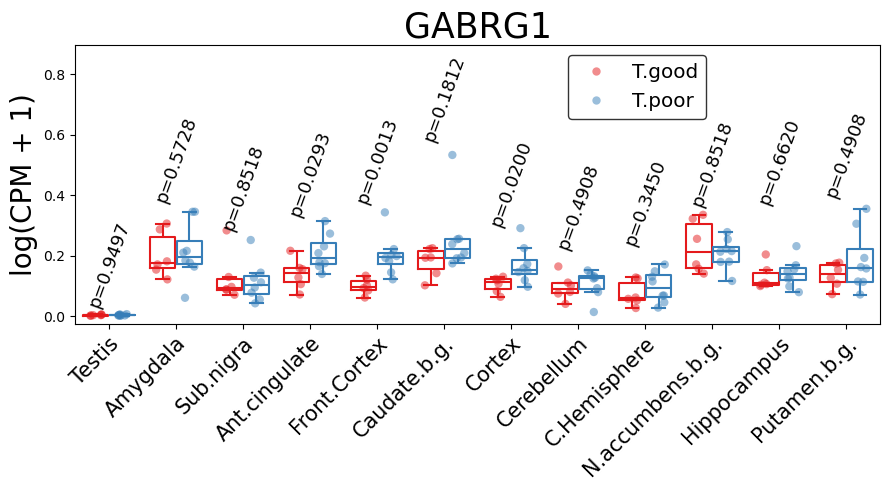

In [51]:
tmp = PlotOneGene("GABRG1",bbox_to_anchor=(0.6, 1))

/tmp/ipykernel_438/3300590048.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_438/3338318438.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_438/3300590048.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


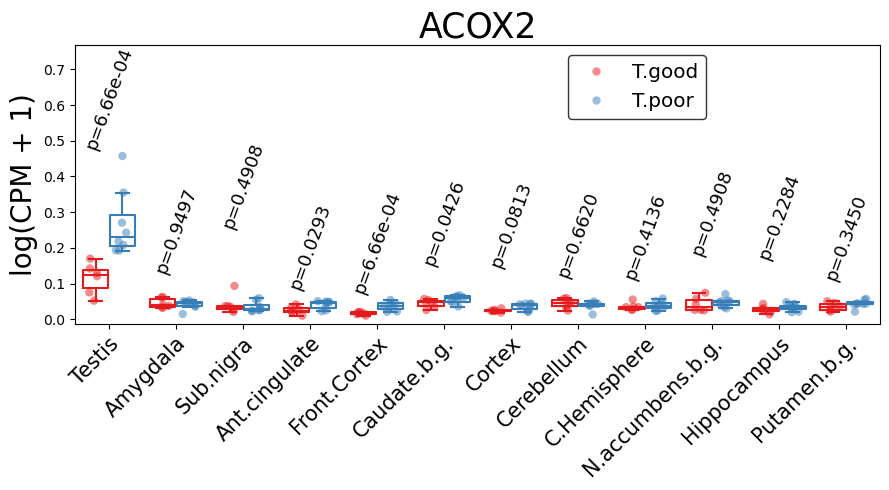

In [52]:
tmp = PlotOneGene("ACOX2",bbox_to_anchor=(0.6, 1))

/tmp/ipykernel_438/2203974469.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_438/3338318438.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_438/2203974469.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


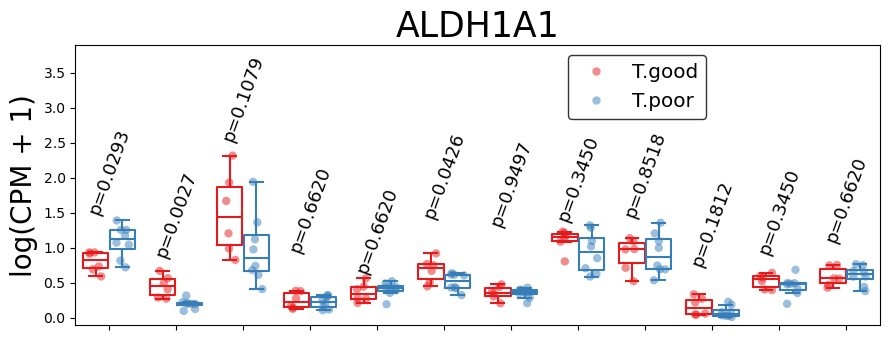

In [65]:
tmp = PlotOneGene2("ALDH1A1",bbox_to_anchor=(0.6, 1))

/tmp/ipykernel_438/2203974469.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_438/3338318438.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_438/2203974469.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


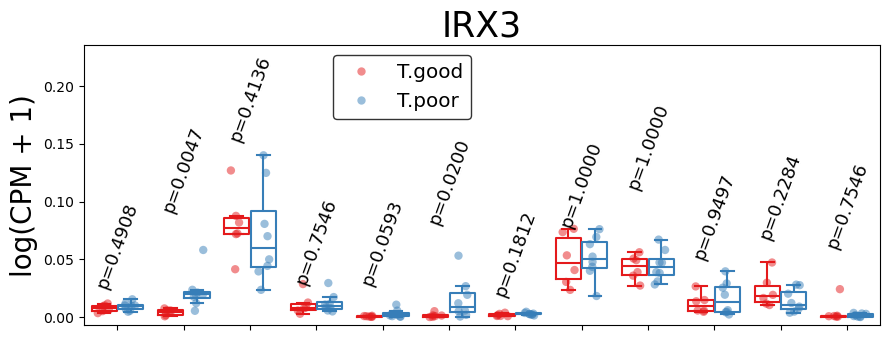

In [66]:
tmp = PlotOneGene2("IRX3",bbox_to_anchor=(0.3, 1))

/tmp/ipykernel_438/2203974469.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_438/3338318438.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_438/2203974469.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


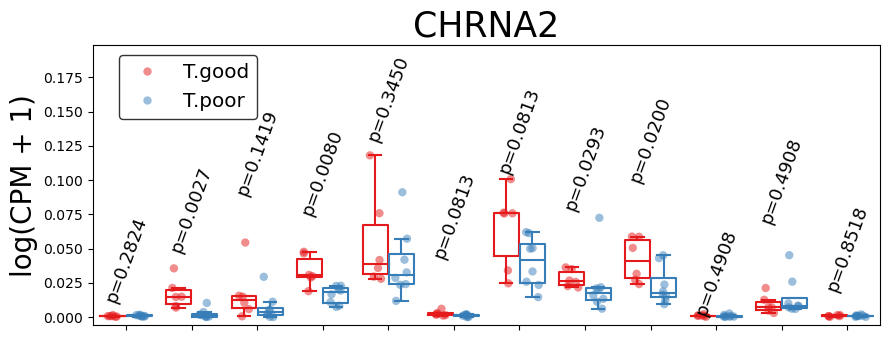

In [67]:
tmp = PlotOneGene2("CHRNA2",bbox_to_anchor=(0.02, 1))